In [2]:
import util
import sheetproc
import sys
from astropy.table import unique

sndata = sheetproc.download_progenitor_data(util.params['SHEET'])
sndata = sheetproc.load_metadata_from_file(sndata, util.params['metadata'])

Loading metadata from: metadata/Type_II_P_II_L.pkl
Loading metadata from: metadata/Type_IIn.pkl
Loading metadata from: metadata/Type_IIb.pkl
Loading metadata from: metadata/Type_Ib_c.pkl
Loading metadata from: metadata/Type_Ia.pkl
Loading metadata from: metadata/Other.pkl


In [37]:
import numpy as np
sp = sndata['Type II-P/II-L'].meta['2017eaw']['osc']['spectra'][0]['data']
wave = np.array([float(w[0]) for w in sp])
flux = np.array([float(w[1]) for w in sp])
z = sndata['Type II-P/II-L'].meta['2017eaw']['osc']['redshift']
print(z)
wave = wave/(1.0+float(z))
print(np.max(wave),np.min(wave))

0.000133
8789.905142616031 3728.606895282928


(5792.0, 5992.0)

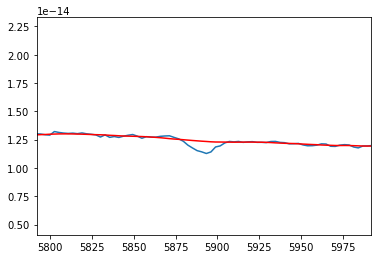

In [41]:
import matplotlib.pyplot as plt
import scipy.signal
import scipy.interpolate
import scipy.optimize

naid=5892.0
naid_half_window=10.0
search_half_window=3.0
wave_window = 40.0
rng = (wave > 4000) & (wave < 6500)
niterate = 10

def line_profile(wave, a, b, c):
    x = (wave-b)/c
    profile = 1.0 - a * np.exp(-0.5*x**2)
    return(profile)

def fit_line_profile(wave, flux):
    
    if (wave[-1] < naid+naid_half_window or
        wave[0]  > naid-naid_half_window):
        return(None)

    rng = (wave < naid+naid_half_window) & (wave > naid-naid_half_window)
    srn = (wave < naid+search_half_window) & (wave > naid-search_half_window)
    
    amp = 1.0 - np.min(flux[rng])
    wav = wave[srn][np.argmin(flux[srn])]
    wid = 7.0
    
    p0=(amp,wav,wid)
    
    print(p0)
    popt, pcov = scipy.optimize.curve_fit(line_profile, wave[rng], flux[rng], 
                                          p0=p0)
    
    return(popt)

def calculate_dwave(wave):
    dwaves = []
    for i in np.arange(len(wave)):
        if i==len(wave)-1: break
        dwaves.append(wave[i+1]-wave[i])

    dwave=np.mean(dwaves)
    return(dwave)

def get_window(wave, wave_window=wave_window):
    dwave = calculate_dwave(wave)
    window = int(np.round(wave_window/dwave))
    if window % 2 == 0: window = window+1
    return(window)

def continuum_smooth(wave, nfhat, flux):
    srms = np.sqrt(np.mean((flux/nfhat-1.0)**2))
    idx = np.where(np.abs(flux/nfhat-1.0)<srms)
    
    f = scipy.interpolate.interp1d(wave[idx], flux[idx], bounds_error=False, fill_value='extrapolate')
    return(scipy.signal.savgol_filter(f(wave), get_window(wave),  1))

nfhat = scipy.signal.savgol_filter(flux, get_window(wave), 1, deriv=0)
for i in np.arange(niterate):
    nfhat = continuum_smooth(wave, nfhat, flux)

plt.plot(wave, flux)
plt.plot(wave, nfhat, color='red')
plt.xlim([naid-100.0,naid+100.0])

(0.08600601731108914, 5893.412476140673, 7.0)
[8.34666723e-02 5.89155183e+03 6.66646719e+00]


(5792.0, 5992.0)

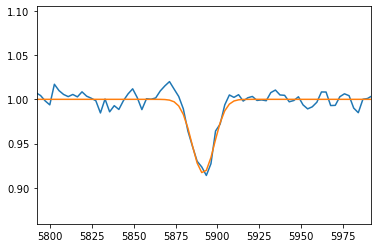

In [40]:
nflux = flux/nfhat
plt.plot(wave, nflux)
popt=fit_line_profile(wave, nflux)
print(popt)
plt.plot(wave, line_profile(wave, *popt))
plt.xlim([naid-100.0,naid+100.0])